In [1]:
from google.colab import files
uploaded = files.upload()  # Upload zip file

Saving features.csv to features (3).csv
Saving stores.csv to stores (3).csv
Saving test.csv to test (3).csv
Saving train.csv to train (3).csv


In [2]:
# Required Libraries
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

# Load each CSV file
train = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")

print("All files loaded successfully!")

print("🔍 Train data preview:")
train.head()

All files loaded successfully!
🔍 Train data preview:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
# Merge the datasets
train = train.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left")
train = train.merge(stores_df, on="Store", how="left")

In [4]:
# Filter to one Store–Dept pair
store_id = 1
dept_id = 1
df = train[(train["Store"] == store_id) & (train["Dept"] == dept_id)].copy()

# Date processing
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["Day"] = df["Date"].dt.day
df["IsHoliday"] = df["IsHoliday"].astype(int)
df["Type"] = df["Type"].map({"A": 0, "B": 1, "C": 2})

# Drop missing rows
df.dropna(inplace=True)

In [5]:
# Features for training
features = ["Temperature", "Fuel_Price", "CPI", "Unemployment",
            "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5",
            "Size", "Type", "Year", "Month", "Week", "Day", "IsHoliday"]

X = df[features]
y = df["Weekly_Sales"]

In [6]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n Evaluation Metrics for Store {store_id}, Dept {dept_id}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")


 Evaluation Metrics for Store 1, Dept 1
MAE  = 2463.72
RMSE = 4105.36
MAPE = 11.14%



 Sample Predictions:
  Actual    Predicted
16119.92 16657.314453
17330.70 16700.947266
16286.40 16889.998047
16680.24 17122.039062
18322.37 16789.509766
19616.22 24777.957031
19251.50 20143.484375
18947.81 20439.800781
27390.81 16508.431641


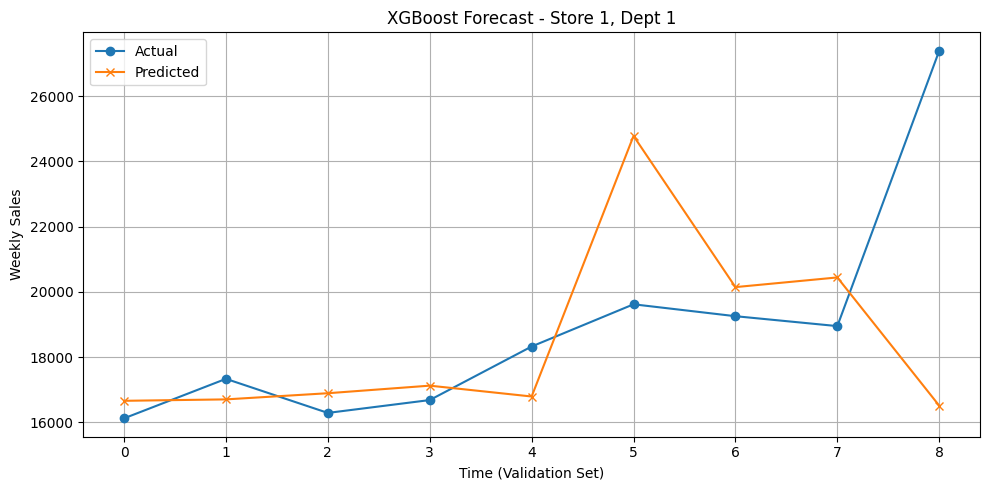

In [8]:

# Sample predictions
sample = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Predicted": y_pred[:10]
})
print("\n Sample Predictions:")
print(sample.to_string(index=False))

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted", marker="x")
plt.title(f"XGBoost Forecast - Store {store_id}, Dept {dept_id}")
plt.xlabel("Time (Validation Set)")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# --- Merge test set with features and store metadata ---
test_df = test_df.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left")
test_df = test_df.merge(stores_df, on="Store", how="left")

# --- Date processing ---
test_df["Date"] = pd.to_datetime(test_df["Date"])
test_df["Year"] = test_df["Date"].dt.year
test_df["Month"] = test_df["Date"].dt.month
test_df["Week"] = test_df["Date"].dt.isocalendar().week.astype(int)
test_df["Day"] = test_df["Date"].dt.day
test_df["IsHoliday"] = test_df["IsHoliday"].astype(int)

# --- Convert Type to numeric ---
test_df["Type"] = test_df["Type"].map({"A": 0, "B": 1, "C": 2})

# --- Drop rows with missing values ---
test_df.dropna(inplace=True)


In [10]:
# --- Match the Store and Dept used for training ---
store_id = 1
dept_id = 1
filtered_test = test_df[(test_df["Store"] == store_id) & (test_df["Dept"] == dept_id)].copy()

# --- Define features (same as used in training) ---
features_used = [
    "Temperature", "Fuel_Price", "CPI", "Unemployment",
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5",
    "Size", "Type", "Year", "Month", "Week", "Day", "IsHoliday"
]


In [11]:
# --- Predict using the trained model ---
X_test_final = filtered_test[features_used]
y_test_pred = model.predict(X_test_final)

# --- Create a DataFrame to display predictions ---
prediction_df = filtered_test[["Date", "Store", "Dept"]].copy()
prediction_df["Predicted_Weekly_Sales"] = y_test_pred

# --- Print a few predictions ---
print("📌 Sample Predictions from test.csv:\n")
print(prediction_df.head(10).to_string(index=False))

📌 Sample Predictions from test.csv:

      Date  Store  Dept  Predicted_Weekly_Sales
2012-11-02      1     1            17567.500000
2012-11-09      1     1            17856.527344
2012-11-16      1     1            24321.105469
2012-11-23      1     1            23449.058594
2012-12-28      1     1            32624.335938
2013-01-04      1     1            28974.167969
2013-01-11      1     1            16136.874023
2013-01-18      1     1            44704.050781
2013-01-25      1     1            23618.558594
2013-02-01      1     1            18246.974609


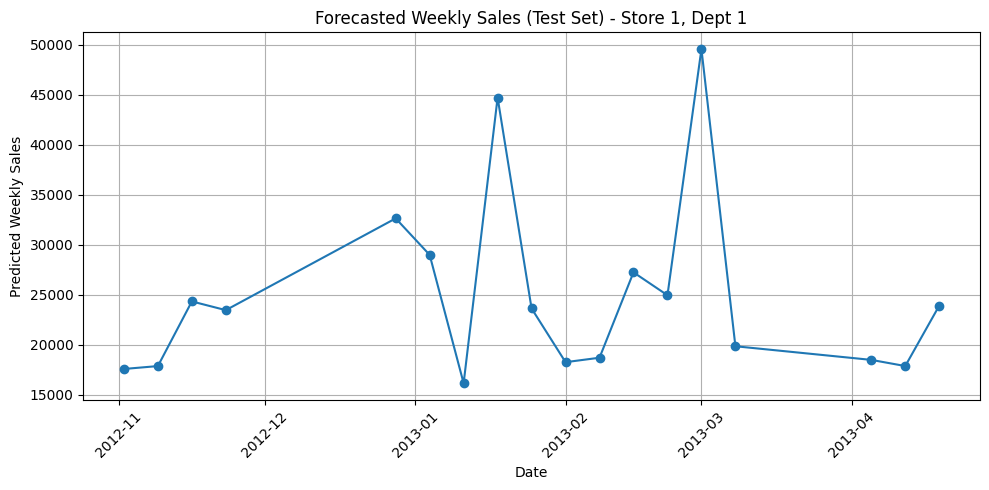

In [12]:
# --- Plot predictions over time ---
plt.figure(figsize=(10, 5))
plt.plot(prediction_df["Date"], prediction_df["Predicted_Weekly_Sales"], marker='o')
plt.title(f"Forecasted Weekly Sales (Test Set) - Store {store_id}, Dept {dept_id}")
plt.xlabel("Date")
plt.ylabel("Predicted Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()